In [215]:
import warnings
import pandas as pd
from app import create_app
from app.models import db, User, Post, Comment, Upvote, Downvote
from sqlalchemy_schemadisplay import create_schema_graph
import plotly.express as px
import graphviz

warnings.filterwarnings('ignore') # filtering out annoying warning messages

# Getting app context from Flask
app = create_app()
app.app_context().push()

In [216]:
# Getting a printout of the Database Schema:
for table in db.metadata.tables.values():
    print("TABLE:", table.name)
    for column in table.c:
        print("COLUMN:", column.name, column.type, "NULLABLE:", column.nullable, "PRIMARY KEY:", column.primary_key,
              "DEFAULT:", column.default)

TABLE: user
COLUMN: id INTEGER NULLABLE: False PRIMARY KEY: True DEFAULT: None
COLUMN: username VARCHAR(20) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: email VARCHAR(120) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: password VARCHAR(60) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: date_created DATETIME NULLABLE: False PRIMARY KEY: False DEFAULT: ColumnDefault(<function datetime.utcnow at 0x119d90940>)
TABLE: post
COLUMN: id INTEGER NULLABLE: False PRIMARY KEY: True DEFAULT: None
COLUMN: topic VARCHAR(100) NULLABLE: True PRIMARY KEY: False DEFAULT: ColumnDefault('None')
COLUMN: title VARCHAR(100) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: date_posted DATETIME NULLABLE: False PRIMARY KEY: False DEFAULT: ColumnDefault(<function datetime.utcnow at 0x119d90f70>)
COLUMN: content TEXT NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: user_id INTEGER NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: view_count INTEGER NULLABLE: F

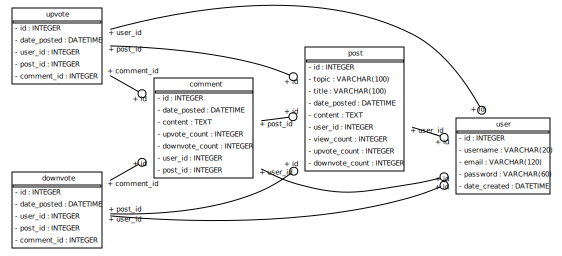

In [220]:
# Plotting a graph of the database schema:
graph = create_schema_graph(metadata=db.metadata, show_datatypes=True, show_indexes=True, rankdir='LR', concentrate=False)
dot_source = graph.to_string()
plot = graphviz.Source(dot_source)
plot.format='png'
plot

In [ ]:
# Looking at users Table:
users = User.query
users_df = pd.read_sql(users.statement, users.session.bind)
users_df.head()

In [ ]:
# Getting histogram manually with pd.cut and groupby:
# pd.cut takes a series and number of bins to assign each element to one of those bins
users_df['datebin'] = pd.cut(users_df['date_created'], 6)
result = users_df.groupby('datebin').count()
result

In [ ]:
fig = px.histogram(users_df, title="Users Added Over Time", x="date_created", text_auto=True, height=600, width=1500,
                   color='username')
fig.update_traces(textfont_size=20, textangle=0, textposition="none", cliponaxis=False)
fig.update_layout(bargap=0.2, yaxis = dict( tickfont = dict(size=20)), xaxis = dict( tickfont = dict(size=20)),
                  legend = dict(font = dict(size = 20)), legend_title = dict(font = dict(size = 20)))
fig.show('png')

In [ ]:
# Getting top 10 posts by view count:
posts = db.session.query(Post, User).join(User)
posts_df = pd.read_sql(posts.statement, posts.session.bind)
posts_df.sort_values(by=['view_count'], ascending=True, inplace=True)
posts_df.tail(5)

In [ ]:
fig = px.bar(posts_df.tail(10), title="Most Viewed Posts", orientation='h', y="title", x='view_count', text_auto=True,
             height=750, width=1600, color="username")
fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(bargap=0.2, yaxis = dict( tickfont = dict(size=20)), xaxis = dict( tickfont = dict(size=20)),
                  legend = dict(font = dict(size = 20)), legend_title = dict(font = dict(size = 20)))
fig.update_yaxes(categoryorder='total ascending')
fig.show('png') # 'png' is set for viewable output on Github.  Otherwise use fig.show() for interactive plot.

In [ ]:
# Getting a treemap of Most Active Users According to Post Volume
posts_per_user = posts_df['username'].value_counts()
fig = px.treemap(posts_per_user, title='Post Volume Per User', path=[px.Constant("user Base"), posts_per_user.index],
                 values='username', color='username', width=1500)
fig.data[0].textinfo = 'label+text+value'
fig.update_traces(textfont_size=18)
fig.show('png') # 'png' is set for viewable output on Github.  Otherwise use fig.show() for interactive plot.